<a href="https://colab.research.google.com/github/kashtienooh/CarND-Advanced-Lane-Lines-master/blob/master/Exercise1_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: Anomaly Detection on Acoustic Data

Anomalous sound detection (ASD) is the task of identifying whether the sound emitted from a target machine is normal or anomalous.
In real-world factories, anomalies rarely occur and are highly diverse.
Therefore, exhaustive patterns of anomalous sounds are impossible to create.
The task is then to detect anomalous sounds using only normal sound clips as training data.
This task cannot be solved as a simple classification problem (anomaly vs healthy), it is then a one-class classification problem.

Anomalous sound detection can be done with three steps:
   - Feature extraction (I)
   - One-class classifier training (II)
   - Decision based on a threshold from the output of the one class classifier (III)
   
Through this assignment, you will focus mostly on tasks (I) and (II),
and the quality of the One-class classifier will be assessed by the Area Under the Curve score when applied to the test dataset.

The model used here is a type of neural network called *autoencoder* (AE). AE is trained to reconstruct the input data distribution while compressing the data and minimizing information loss during this process.
Thus, you will modify the features and Neural Network used in this notebook to improve the anomalous sound detection performances.

The dataset is composed of two different machines, a Pump and a Valve. For each machine you have:
- A training dataset composed only of healthy data
- A test dataset composed both of healthy and abnormal data


## Download Dataset

In [ ]:
!gdown --id 1awehzph21KiJaQPUrmqUxrqG9eFf1i0n
!gdown --id 1dpE0JjJyXq8bhqMdCzs_JsEfj29xD-xQ
!unzip dev_data_pump_04.zip
!unzip dev_data_valve_00.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1awehzph21KiJaQPUrmqUxrqG9eFf1i0n
From (redirected): https://drive.google.com/uc?id=1awehzph21KiJaQPUrmqUxrqG9eFf1i0n&confirm=t&uuid=4eb47cab-da88-4f69-b20c-177206528b29
To: /content/dev_data_pump_04.zip
100% 199M/199M [00:08<00:00, 24.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1dpE0JjJyXq8bhqMdCzs_JsEfj29xD-xQ
From (redirected): https://drive.google.com/uc?id=1dpE0JjJyXq8bhqMdCzs_JsEfj29xD-xQ&confirm=t&uuid=ed717490-d4d6-45a0-8e07-80baa0ffd8ac
To: /content/dev_da

## Imports

In [ ]:
import os
import sys
import librosa
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm

## Audio file loading and mel-spectrogram feature extraction

The code is adapted from https://github.com/MIMII-hitachi/mimii_baseline

Copyright (C) 2019 Hitachi, Ltd. All right reserved.

Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, "MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection," arXiv preprint arXiv:1909.09347, 2019.

In [ ]:
########################################################################
# import additional python-library
########################################################################
import librosa.core
import librosa.feature

# wav file Input
def file_load(wav_name, mono=False):
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        raise OSError("file_broken or not exists!! : {}".format(wav_name))


def demux_wav(wav_name, channel=0):
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, numpy.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        print(f'{msg}')

########################################################################
# feature extractor
########################################################################
def file_to_vector_array(file_name,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):

    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * numpy.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vectorarray_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vectorarray_size < 1:
        return numpy.empty((0, dims), float)

    # 06 generate feature vectors by concatenating multi_frames
    vectorarray = numpy.zeros((vectorarray_size, dims), float)
    for t in range(frames):
        vectorarray[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vectorarray_size].T

    return vectorarray

## PyTorch Dataset class definition

To define and optimize a neural network, we will use the library [PyTorch](http://pytorch.org).

In [ ]:
DATA_PATH = "."
MACHINE = "pump_04" # Choice between  "valve_00" or "pump_04"

In [ ]:
class MIMII(Dataset):
    def __init__(self, root, machine, train=True, transform=None, target_transform=None):
        if train:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "train")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        else:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "test")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.audio_path, self.audio_files[idx])
        label = self.labels[idx]
        if self.transform:
            f = self.transform(file_path)
        else:
            # default feature representation
            f = file_to_vector_array(file).astype(numpy.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return f, label

In [ ]:
# Parameters of the feature extraction
melsp_params = dict(n_mels=64,
                    frames=1,
                    n_fft=1024,
                    hop_length=512,
                    power=2.0)

feature_extraction_pipeline = T.Compose([
    T.Lambda(lambda file: file_to_vector_array(file, **melsp_params).astype(numpy.float32)),
    T.ToTensor()
])

In [ ]:
#Pytorch dataset
data_train = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=True,
    transform=feature_extraction_pipeline
)

data_test = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=False,
    transform=feature_extraction_pipeline
)

print(len(data_train), len(data_test))

602 200


## Autoencoder model definition


In [ ]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128,512),
            nn.ReLU(),
            nn.Linear(512,input_dim),
            )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction, feature

In [ ]:
duration = 10  # s
sr = 16000  # Hz
input_dim = int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
print(input_dim)

model = DenseAutoencoder(input_dim)
print(model)

20032
DenseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20032, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=20032, bias=True)
  )
)


## Training

In [ ]:
# Training parameters
batch_size = 32
epochs = 5

In [ ]:
# PyTorch data loaders allow to iterate batch-wise over a dataset
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# Stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters())

# Mean Squared Error (MSE) loss function to be minimized
loss_fn = nn.MSELoss()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_running = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        x = x.flatten(start_dim=1)
        optimizer.zero_grad()
        x_pred,features = model(x)

        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()

        # Backpropagation
        loss_running += loss.item()

    print(f"loss: {loss_running/len(dataloader):>7f}")


def test_loop(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = numpy.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    return test_losses,numpy.array(store_feature)

In [ ]:
%%time
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, print_every=1)

Epoch 1
-------------------------------


100%|██████████| 18/18 [00:35<00:00,  1.99s/it]


loss: 188.715257
Epoch 2
-------------------------------


100%|██████████| 18/18 [00:16<00:00,  1.12it/s]


loss: 16.939220
Epoch 3
-------------------------------


100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


loss: 12.713158
Epoch 4
-------------------------------


100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


loss: 12.150594
Epoch 5
-------------------------------


100%|██████████| 18/18 [00:16<00:00,  1.12it/s]

loss: 12.140142
CPU times: user 1min 18s, sys: 49.2 s, total: 2min 7s
Wall time: 1min 38s


## Prediction and evaluation

In [ ]:
# 0: normal, 1: anomaly
y_pred, extracted_features_test = test_loop(data_test, model, loss_fn)
y_true = data_test.labels

print(f"AUC score from from the model {metrics.roc_auc_score(y_true, y_pred):.2f}")

AUC score from from the model 0.82


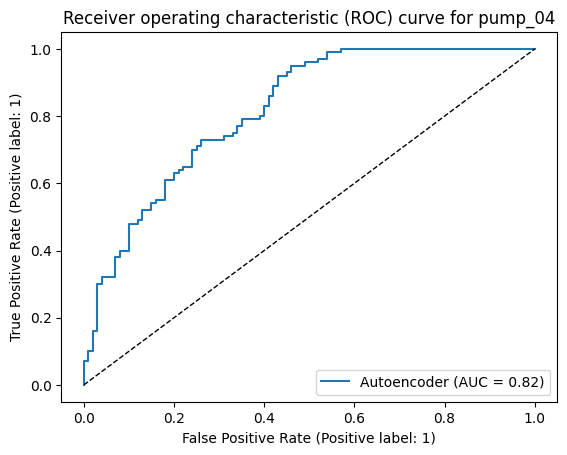

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, y_pred, name="Autoencoder")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"Receiver operating characteristic (ROC) curve for {MACHINE}");

## One-Class SVM and Isolation Forest

From the trained AutoEncoder, use the bottelneck features to train a (1) One-Class SVM and (2) Isolation Forest, and report the accuracy, F1-score and confusion matrix of each method.

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [ ]:
#Get normal training features
y_pred_train, extracted_features_train = test_loop(data_train, model, loss_fn)

One-Class SVM

In [ ]:
#define the OneClassSVM here
clf = OneClassSVM()
#Fit OneClassSVM here using training data
clf.fit(extracted_features_train, y_pred_train)
predicted_score_clf = clf.score_samples(extracted_features_test) # Predict the anomaly score for test data
print(f"AUC score from One-Class SVM: {metrics.roc_auc_score(y_true, -predicted_score_clf):.2f}")

AUC score from One-Class SVM: 0.57


Isolation Forest

In [ ]:
#Define IsolationForest here
IsoTree = IsolationForest()
#Fit IsolationForest here using training data
IsoTree.fit(extracted_features_train, y_pred_train)
#Predict the anomaly score for test data
predicted_score_iso = IsoTree.score_samples(extracted_features_test)

print(f"AUC score from Isolation Forest: {metrics.roc_auc_score(y_true, -predicted_score_iso):.2f}")

AUC score from Isolation Forest: 0.64


PCA of the spectrograms to reduce the input dimension

In [ ]:
#Extract spectrograms of training and testing
flatten_spectogram_train = []
for idx, (x, _) in enumerate(data_train):
  x = x.flatten()
  flatten_spectogram_train.append(x.numpy())
train_spec = numpy.array(flatten_spectogram_train)

flatten_spectogram_test = []
for idx, (x, _) in enumerate(data_test):
  x = x.flatten()
  flatten_spectogram_test.append(x.numpy())
test_spec = numpy.array(flatten_spectogram_test)

Apply PCA to fit and transform the training data and transform also the test data

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=32)
#Fit and transform the training data (train_spec)
pca_train_spec = pca.fit_transform(train_spec)
#Transform the testing data (test_spec)
pca_test_spec = pca.transform(test_spec)


Applying OneClassSVM and IsolationForest on the new features.

In [ ]:
clf_pca = OneClassSVM()
clf_pca.fit(pca_train_spec, train_spec)
predicted_score_clf_pca = clf.score_samples(pca_test_spec) # Predict the anomaly score for test data
print(f"AUC score from One-Class SVM with PCA: {metrics.roc_auc_score(y_true, -predicted_score_clf_pca):.2f}")

AUC score from One-Class SVM with PCA: 0.67


In [ ]:
IsoTree_pca = IsolationForest()
IsoTree_pca.fit(pca_train_spec, train_spec)
#Predict the anomaly score for test data
predicted_score_iso_pca = IsoTree_pca.score_samples(pca_test_spec)
print(f"AUC score from Isolation Forest with PCA: {metrics.roc_auc_score(y_true, -predicted_score_iso_pca):.2f}")

AUC score from Isolation Forest with PCA: 0.88


In [ ]:
#From the plots of reconstruction error form the training and testing datasets, we choose a threshold of 15
##################
error_threshold = 15 ##
##################
print("Chosen Threshold: %d" % (error_threshold))

Chosen Threshold: 15


In [ ]:
print("For Reconstruction error in the Autoencoder:")
pred_rec_error = y_pred < error_threshold
print(f"Accuracy: {metrics.accuracy_score(y_true, pred_rec_error):.2f}")
tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_rec_error).ravel()
print("TPR and FPR: %.2f %.2f" % ((tp/(tp+fn)), (fp/(fp+tn))))
print(f"F1-score: {metrics.f1_score(y_true, pred_rec_error):.2f}")
print(f"AUC score: {metrics.roc_auc_score(y_true, y_pred):.2f}")
print("\n")

For Reconstruction error in the Autoencoder:
Accuracy: 0.29
TPR and FPR: 0.24 0.66
F1-score: 0.25
AUC score: 0.82


